In [1]:
import pandas as pd

# Optional display settings for better notebook formatting
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 10)       # Limit number of rows shown
pd.set_option('display.width', 1000)        # Width of the display in characters

# Load datasets
train = pd.read_csv("train-.csv")  # Provider-level fraud labels
benef = pd.read_csv("train_Beneficiarydata.csv")  # Beneficiary-level details
inpat = pd.read_csv("train_Inpatientdata.csv")  # Inpatient claims
outpat = pd.read_csv("train_Outpatientdata.csv")  # Outpatient claims

# Calculate inpatient claims at provider level
ip_provider_amounts = inpat.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index()
ip_provider_amounts = ip_provider_amounts.rename(columns={'InscClaimAmtReimbursed': 'IP_Claims_Total'})

# Calculate outpatient claims at provider level
op_provider_amounts = outpat.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index()
op_provider_amounts = op_provider_amounts.rename(columns={'InscClaimAmtReimbursed': 'OP_Claims_Total'})

# Merge IP and OP provider totals
provider_claims = pd.merge(ip_provider_amounts, op_provider_amounts, on='Provider', how='outer').fillna(0)

# Add derived features
provider_claims['Total_Reimbursed'] = provider_claims['IP_Claims_Total'] + provider_claims['OP_Claims_Total']
provider_claims['Claim_Ratio'] = provider_claims['IP_Claims_Total'] / (provider_claims['OP_Claims_Total'] + 1)

# Count unique inpatient and outpatient visits per provider
inpat_visits = inpat.groupby('Provider').size().reset_index(name='Inpatient_Visits')
outpat_visits = outpat.groupby('Provider').size().reset_index(name='Outpatient_Visits')

# Merge visit counts into main dataframe
provider_claims = pd.merge(provider_claims, inpat_visits, on='Provider', how='left').fillna(0)
provider_claims = pd.merge(provider_claims, outpat_visits, on='Provider', how='left').fillna(0)

# Add fraud labels
final_df = pd.merge(provider_claims, train[['Provider', 'PotentialFraud']], on='Provider', how='outer')

# Cross Check:
print("Total sums:")
print("Total IP Claims:", final_df['IP_Claims_Total'].sum())
print("Total OP Claims :", final_df['OP_Claims_Total'].sum())


Total sums:
Total IP Claims: 408297020.0
Total OP Claims : 148246120.0


In [2]:
final_df

,Provider,IP_Claims_Total,OP_Claims_Total,Total_Reimbursed,Claim_Ratio,Inpatient_Visits,Outpatient_Visits,PotentialFraud
0,PRV51001,97000.0,7640.0,104640.0,12.694673,5.0,20.0,No
1,PRV51003,573000.0,32670.0,605670.0,17.538490,62.0,70.0,Yes
2,PRV51004,0.0,52170.0,52170.0,0.000000,0.0,149.0,No
3,PRV51005,0.0,280910.0,280910.0,0.000000,0.0,1165.0,Yes
4,PRV51007,19000.0,14710.0,33710.0,1.291551,3.0,69.0,No
...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,10640.0,10640.0,0.000000,0.0,28.0,No
5406,PRV57760,0.0,4770.0,4770.0,0.000000,0.0,22.0,No
5407,PRV57761,0.0,18470.0,18470.0,0.000000,0.0,82.0,No
5408,PRV57762,0.0,1900.0,1900.0,0.000000,0.0,1.0,No


In [16]:
# Feature Engineering Block
# Add engineered features
#final_df['Total_Claims'] = final_df['IP_Claims_Total'] + final_df['OP_Claims_Total']
final_df['Claim_Ratio_IP_to_OP'] = final_df['IP_Claims_Total'] / (final_df['OP_Claims_Total'] + 1)
final_df['Claim_Ratio_OP_to_Total'] = final_df['OP_Claims_Total'] / (final_df['Total_Reimbursed'] + 1)


# Calculate average and standard deviation of claims per visit
final_df['Avg_IP_Claim'] = final_df['IP_Claims_Total'] / (final_df['Inpatient_Visits'] + 1)
final_df['Avg_OP_Claim'] = final_df['OP_Claims_Total'] / (final_df['Outpatient_Visits'] + 1)

# Calculate total visits and ratio
final_df['Total_Visits'] = final_df['Inpatient_Visits'] + final_df['Outpatient_Visits']
final_df['IP_to_Total_Visit_Ratio'] = final_df['Inpatient_Visits'] / (final_df['Total_Visits'] + 1)
final_df['OP_to_Total_Visit_Ratio'] = final_df['Outpatient_Visits'] / (final_df['Total_Visits'] + 1)

# Save final dataframe with engineered features
final_df.to_csv('final_provider_dataset.csv', index=False)

In [18]:
final_df

,Provider,IP_Claims_Total,OP_Claims_Total,Total_Reimbursed,Claim_Ratio,Inpatient_Visits,Outpatient_Visits,PotentialFraud,Claim_Ratio_IP_to_OP,Claim_Ratio_OP_to_Total,Avg_IP_Claim,Avg_OP_Claim,Total_Visits,IP_to_Total_Visit_Ratio,OP_to_Total_Visit_Ratio
0,PRV51001,97000.0,7640.0,104640.0,12.694673,5.0,20.0,No,12.694673,0.073012,16166.666667,363.809524,25.0,0.192308,0.769231
1,PRV51003,573000.0,32670.0,605670.0,17.538490,62.0,70.0,Yes,17.538490,0.053940,9095.238095,460.140845,132.0,0.466165,0.526316
2,PRV51004,0.0,52170.0,52170.0,0.000000,0.0,149.0,No,0.000000,0.999981,0.000000,347.800000,149.0,0.000000,0.993333
3,PRV51005,0.0,280910.0,280910.0,0.000000,0.0,1165.0,Yes,0.000000,0.999996,0.000000,240.917667,1165.0,0.000000,0.999142
4,PRV51007,19000.0,14710.0,33710.0,1.291551,3.0,69.0,No,1.291551,0.436356,4750.000000,210.142857,72.0,0.041096,0.945205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,10640.0,10640.0,0.000000,0.0,28.0,No,0.000000,0.999906,0.000000,366.896552,28.0,0.000000,0.965517
5406,PRV57760,0.0,4770.0,4770.0,0.000000,0.0,22.0,No,0.000000,0.999790,0.000000,207.391304,22.0,0.000000,0.956522
5407,PRV57761,0.0,18470.0,18470.0,0.000000,0.0,82.0,No,0.000000,0.999946,0.000000,222.530120,82.0,0.000000,0.987952
5408,PRV57762,0.0,1900.0,1900.0,0.000000,0.0,1.0,No,0.000000,0.999474,0.000000,950.000000,1.0,0.000000,0.500000


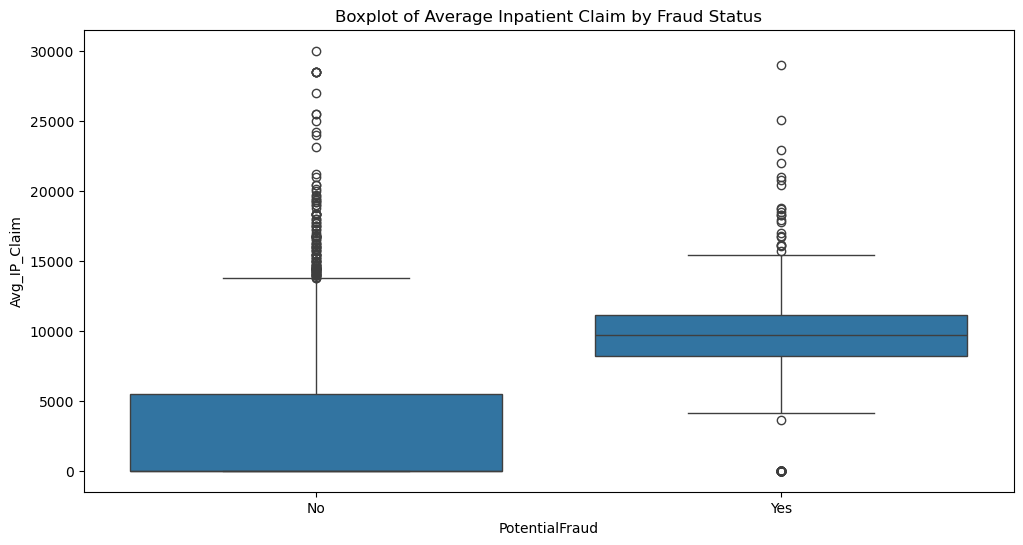

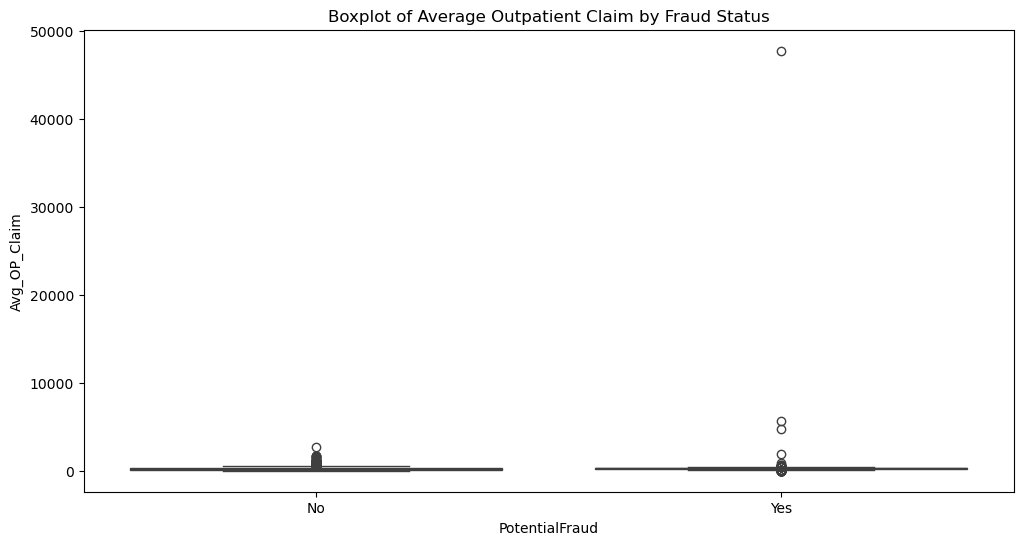

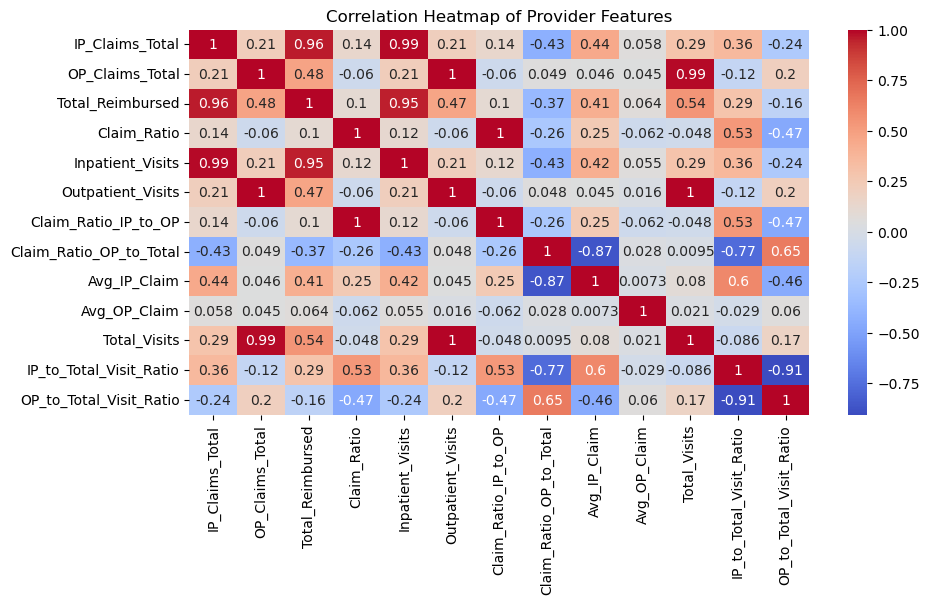

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns




plt.figure(figsize=(12, 6))
sns.boxplot(x='PotentialFraud', y='Avg_IP_Claim', data=final_df)
plt.title('Boxplot of Average Inpatient Claim by Fraud Status')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='PotentialFraud', y='Avg_OP_Claim', data=final_df)
plt.title('Boxplot of Average Outpatient Claim by Fraud Status')
plt.show()

plt.figure(figsize=(10, 5))
sns.heatmap(final_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Provider Features')
plt.show()
 


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_style("whitegrid")

# Boxplots for cleaned numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=final_df_cleaned[col])
    plt.title(col)

plt.tight_layout()
plt.show()

# Distribution plots (histograms) for cleaned numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(final_df_cleaned[col], bins=30, kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

# Countplot for fraud distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=final_df_cleaned['PotentialFraud'])
plt.title("Fraud Distribution")
plt.xlabel("Potential Fraud (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


NameError: name 'numeric_columns' is not defined

<Figure size 1500x1000 with 0 Axes>

In [ ]:
import numpy as np

def remove_outliers(df, columns):
    """
    Removes outliers from specified numerical columns using the IQR method.
    """
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Define numeric columns to check for outliers
numeric_columns = [
    'IP_Claims_Total', 'OP_Claims_Total', 'Total_Claims', 'Claim_Ratio_IP_to_OP',
    'Claim_Ratio_OP_to_Total', 'Inpatient_Visits', 'Outpatient_Visits',
    'Avg_IP_Claim', 'Avg_OP_Claim', 'Total_Visits', 'IP_to_Total_Visit_Ratio', 'OP_to_Total_Visit_Ratio'
]

# Apply outlier removal
final_df_cleaned = remove_outliers(final_df, numeric_columns)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to remove outliers using IQR method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# List of numerical columns to check for outliers
numeric_columns = [
    'IP_Claims_Total', 'OP_Claims_Total', 'Total_Claims', 'Claim_Ratio_IP_to_OP',
    'Claim_Ratio_OP_to_Total', 'Inpatient_Visits', 'Outpatient_Visits',
    'Avg_IP_Claim', 'Avg_OP_Claim', 'Total_Visits', 'IP_to_Total_Visit_Ratio', 'OP_to_Total_Visit_Ratio'
]

# Remove outliers
final_df_cleaned = remove_outliers(final_df, numeric_columns)

# Selecting the most important features for correlation heatmap
selected_features = [
    'IP_Claims_Total', 'OP_Claims_Total', 'Inpatient_Visits',
    'Outpatient_Visits', 'Total_Visits', 
]

# Compute correlation matrix
corr_matrix = final_df_cleaned[selected_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Key Features")
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_style("whitegrid")

# Boxplots for key numerical features
numeric_columns = [
    'IP_Claims_Total', 'OP_Claims_Total', 'Total_Claims', 'Claim_Ratio_IP_to_OP',
    'Claim_Ratio_OP_to_Total', 'Inpatient_Visits', 'Outpatient_Visits',
    'Avg_IP_Claim', 'Avg_OP_Claim', 'Total_Visits', 'IP_to_Total_Visit_Ratio', 'OP_to_Total_Visit_Ratio'
]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=final_df_cleaned[col])
    plt.title(col)

plt.tight_layout()
plt.show()

# Distribution plots (histograms) for key numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(final_df_cleaned[col], bins=30, kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

# Countplot for fraud distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=final_df['PotentialFraud'])
plt.title("Fraud Distribution")
plt.xlabel("Potential Fraud (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


In [ ]:
final_df_cleaned

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Save the cleaned dataset
final_df_cleaned.to_csv('final_provider_dataset_outliers_handled.csv', index=False)
final_df.to_csv('final_provider_dataset.csv', index=False)

# Select key numeric features for comparison
key_features = ['IP_Claims_Total', 'OP_Claims_Total', 'Total_Claims', 
                'Inpatient_Visits', 'Outpatient_Visits', 'Avg_IP_Claim', 'Avg_OP_Claim']

# Load datasets
original_df = pd.read_csv('final_provider_dataset.csv')
cleaned_df = pd.read_csv('final_provider_dataset_outliers_handled.csv')

# Boxplot comparison
plt.figure(figsize=(14, 12))
for i, col in enumerate(key_features, 1):
    plt.subplot(len(key_features), 2, 2*i - 1)
    sns.boxplot(x=original_df[col], color='lightblue')
    plt.title(f"{col} - Original")

    plt.subplot(len(key_features), 2, 2*i)
    sns.boxplot(x=cleaned_df[col], color='lightgreen')
    plt.title(f"{col} - Cleaned")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('final_provider_dataset.csv')

# Check distribution of inpatient claim values
print("Before outlier removal:")
print(df[['IP_Claims_Total', 'Inpatient_Visits', 'Avg_IP_Claim']].describe())

# Check number of zeros
print("Number of zero values:")
print((df[['IP_Claims_Total', 'Inpatient_Visits', 'Avg_IP_Claim']] == 0).sum())


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('final_provider_dataset.csv')

# Identify numeric columns (excluding 'PotentialFraud')
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#numeric_cols.remove('PotentialFraud')

# Separate inpatient columns for more lenient filtering
inpatient_cols = ['IP_Claims_Total', 'Inpatient_Visits', 'Avg_IP_Claim']
other_cols = [col for col in numeric_cols if col not in inpatient_cols]

# Function to remove outliers using the IQR method
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Function to remove outliers using percentile-based filtering
def remove_outliers_percentile(df, cols, lower=1, upper=99):
    for col in cols:
        low, high = np.percentile(df[col], [lower, upper])
        df = df[(df[col] >= low) & (df[col] <= high)]
    return df

# Apply different filtering methods
df_cleaned = remove_outliers_percentile(df, inpatient_cols)  # Lenient filtering for inpatient
df_cleaned = remove_outliers_iqr(df_cleaned, other_cols)  # Standard IQR filtering for other cols

# Save the cleaned dataset
df_cleaned.to_csv('final_provider_dataset_outliers_handled.csv', index=False)

# Print summary before and after
print("Before Outlier Removal:")
print(df[numeric_cols].describe())
print("\nAfter Outlier Removal:")
print(df_cleaned[numeric_cols].describe())


In [ ]:
# Reload the cleaned dataset
df_cleaned = pd.read_csv('final_provider_dataset_outliers_handled.csv')

# Select important features for visualization
selected_cols = ['IP_Claims_Total', 'OP_Claims_Total', 'Total_Claims', 'Avg_IP_Claim', 'Avg_OP_Claim']

# Create side-by-side boxplots
plt.figure(figsize=(16, 10))
for i, col in enumerate(selected_cols, 1):
    plt.subplot(len(selected_cols), 2, 2*i - 1)
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f"{col} - Original")

    plt.subplot(len(selected_cols), 2, 2*i)
    sns.boxplot(x=df_cleaned[col], color='lightgreen')
    plt.title(f"{col} - Cleaned")

plt.tight_layout()
plt.show()


In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('final_provider_dataset.csv')

# Avoid division by zero by adding +1 where needed
df['IP_Claims_StdDev'] = df.groupby('Provider')['IP_Claims_Total'].transform('std').fillna(0)
df['OP_Claims_StdDev'] = df.groupby('Provider')['OP_Claims_Total'].transform('std').fillna(0)

df['IP_Claims_Max'] = df.groupby('Provider')['IP_Claims_Total'].transform('max')
df['OP_Claims_Max'] = df.groupby('Provider')['OP_Claims_Total'].transform('max')

df['IP_Claims_Min'] = df.groupby('Provider')['IP_Claims_Total'].transform('min')
df['OP_Claims_Min'] = df.groupby('Provider')['OP_Claims_Total'].transform('min')

df['Total_Visits'] = df['Inpatient_Visits'] + df['Outpatient_Visits']

df['IP_Visit_Rate'] = df['Inpatient_Visits'] / (df['Total_Visits'] + 1)
df['OP_Visit_Rate'] = df['Outpatient_Visits'] / (df['Total_Visits'] + 1)

df['Cost_per_IP_Visit'] = df['Total_Reimbursed'] / (df['Inpatient_Visits'] + 1)
df['Cost_per_OP_Visit'] = df['Total_Reimbursed'] / (df['Outpatient_Visits'] + 1)
df['Cost_per_Visit'] = df['Total_Reimbursed'] / (df['Total_Visits'] + 1)

df['Avg_IP_Claim_Per_Visit'] = df['IP_Claims_Total'] / (df['Inpatient_Visits'] + 1)
df['Avg_OP_Claim_Per_Visit'] = df['OP_Claims_Total'] / (df['Outpatient_Visits'] + 1)

# Save the new dataset
df.to_csv('final_provider_dataset_enhanced.csv', index=False)

print("✅ Feature Engineering Complete. Saved as 'final_provider_dataset_enhanced.csv'")


✅ Feature Engineering Complete. Saved as 'final_provider_dataset_enhanced.csv'


In [3]:
df

,Provider,IP_Claims_Total,OP_Claims_Total,Total_Reimbursed,Claim_Ratio,Inpatient_Visits,Outpatient_Visits,PotentialFraud,Claim_Ratio_IP_to_OP,Claim_Ratio_OP_to_Total,...,OP_Claims_Max,IP_Claims_Min,OP_Claims_Min,IP_Visit_Rate,OP_Visit_Rate,Cost_per_IP_Visit,Cost_per_OP_Visit,Cost_per_Visit,Avg_IP_Claim_Per_Visit,Avg_OP_Claim_Per_Visit
0,PRV51001,97000.0,7640.0,104640.0,12.694673,5.0,20.0,No,12.694673,0.073012,...,7640.0,97000.0,7640.0,0.192308,0.769231,17440.000000,4982.857143,4024.615385,16166.666667,363.809524
1,PRV51003,573000.0,32670.0,605670.0,17.538490,62.0,70.0,Yes,17.538490,0.053940,...,32670.0,573000.0,32670.0,0.466165,0.526316,9613.809524,8530.563380,4553.909774,9095.238095,460.140845
2,PRV51004,0.0,52170.0,52170.0,0.000000,0.0,149.0,No,0.000000,0.999981,...,52170.0,0.0,52170.0,0.000000,0.993333,52170.000000,347.800000,347.800000,0.000000,347.800000
3,PRV51005,0.0,280910.0,280910.0,0.000000,0.0,1165.0,Yes,0.000000,0.999996,...,280910.0,0.0,280910.0,0.000000,0.999142,280910.000000,240.917667,240.917667,0.000000,240.917667
4,PRV51007,19000.0,14710.0,33710.0,1.291551,3.0,69.0,No,1.291551,0.436356,...,14710.0,19000.0,14710.0,0.041096,0.945205,8427.500000,481.571429,461.780822,4750.000000,210.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,10640.0,10640.0,0.000000,0.0,28.0,No,0.000000,0.999906,...,10640.0,0.0,10640.0,0.000000,0.965517,10640.000000,366.896552,366.896552,0.000000,366.896552
5406,PRV57760,0.0,4770.0,4770.0,0.000000,0.0,22.0,No,0.000000,0.999790,...,4770.0,0.0,4770.0,0.000000,0.956522,4770.000000,207.391304,207.391304,0.000000,207.391304
5407,PRV57761,0.0,18470.0,18470.0,0.000000,0.0,82.0,No,0.000000,0.999946,...,18470.0,0.0,18470.0,0.000000,0.987952,18470.000000,222.530120,222.530120,0.000000,222.530120
5408,PRV57762,0.0,1900.0,1900.0,0.000000,0.0,1.0,No,0.000000,0.999474,...,1900.0,0.0,1900.0,0.000000,0.500000,1900.000000,950.000000,950.000000,0.000000,950.000000


In [7]:
import pandas as pd
import numpy as np

# Load inpatient and outpatient datasets
inpat = pd.read_csv('Train_Inpatientdata.csv')
outpat = pd.read_csv('Train_Outpatientdata.csv')

# Convert claim dates to datetime format
inpat['ClaimDate'] = pd.to_datetime(inpat['ClaimStartDt'], errors='coerce')
outpat['ClaimDate'] = pd.to_datetime(outpat['ClaimStartDt'], errors='coerce')

# Extract month and year
inpat['ClaimMonth'] = inpat['ClaimDate'].dt.to_period('M')
outpat['ClaimMonth'] = outpat['ClaimDate'].dt.to_period('M')

# Aggregate claim counts per provider per month
inpat_trends = inpat.groupby(['Provider', 'ClaimMonth']).size().reset_index(name='IP_Claims_Per_Month')
outpat_trends = outpat.groupby(['Provider', 'ClaimMonth']).size().reset_index(name='OP_Claims_Per_Month')

# Aggregate provider-level statistics
ip_temporal_features = inpat_trends.groupby('Provider').agg({
    'IP_Claims_Per_Month': ['mean', 'max', 'std']
}).reset_index()
ip_temporal_features.columns = ['Provider', 'Avg_IP_Claims_Per_Month', 'Max_IP_Claims_Per_Month', 'Std_IP_Claims_Per_Month']

op_temporal_features = outpat_trends.groupby('Provider').agg({
    'OP_Claims_Per_Month': ['mean', 'max', 'std']
}).reset_index()
op_temporal_features.columns = ['Provider', 'Avg_OP_Claims_Per_Month', 'Max_OP_Claims_Per_Month', 'Std_OP_Claims_Per_Month']

# Merge with final dataset
df = pd.read_csv('final_provider_dataset.csv')
df = df.merge(ip_temporal_features, on='Provider', how='left').fillna(0)
df = df.merge(op_temporal_features, on='Provider', how='left').fillna(0)

# Save the enhanced dataset
df.to_csv('final_provider_dataset_enhanced.csv', index=False)

print("✅ Temporal trend features added and dataset saved!")


✅ Temporal trend features added and dataset saved!


In [17]:
df = pd.read_csv('final_provider_dataset_enhanced.csv')

In [19]:
df

,Provider,IP_Claims_Total,OP_Claims_Total,Total_Reimbursed,Claim_Ratio,Inpatient_Visits,Outpatient_Visits,PotentialFraud,Claim_Ratio_IP_to_OP,Claim_Ratio_OP_to_Total,...,Avg_OP_Claim,Total_Visits,IP_to_Total_Visit_Ratio,OP_to_Total_Visit_Ratio,Avg_IP_Claims_Per_Month,Max_IP_Claims_Per_Month,Std_IP_Claims_Per_Month,Avg_OP_Claims_Per_Month,Max_OP_Claims_Per_Month,Std_OP_Claims_Per_Month
0,PRV51001,97000.0,7640.0,104640.0,12.694673,5.0,20.0,No,12.694673,0.073012,...,363.809524,25.0,0.192308,0.769231,1.666667,2.0,0.577350,2.000000,3.0,0.816497
1,PRV51003,573000.0,32670.0,605670.0,17.538490,62.0,70.0,Yes,17.538490,0.053940,...,460.140845,132.0,0.466165,0.526316,4.769231,9.0,2.087816,5.833333,9.0,1.696699
2,PRV51004,0.0,52170.0,52170.0,0.000000,0.0,149.0,No,0.000000,0.999981,...,347.800000,149.0,0.000000,0.993333,0.000000,0.0,0.000000,12.416667,19.0,3.629634
3,PRV51005,0.0,280910.0,280910.0,0.000000,0.0,1165.0,Yes,0.000000,0.999996,...,240.917667,1165.0,0.000000,0.999142,0.000000,0.0,0.000000,89.615385,113.0,28.871954
4,PRV51007,19000.0,14710.0,33710.0,1.291551,3.0,69.0,No,1.291551,0.436356,...,210.142857,72.0,0.041096,0.945205,1.000000,1.0,0.000000,5.750000,9.0,2.094365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,10640.0,10640.0,0.000000,0.0,28.0,No,0.000000,0.999906,...,366.896552,28.0,0.000000,0.965517,0.000000,0.0,0.000000,2.333333,6.0,1.497473
5406,PRV57760,0.0,4770.0,4770.0,0.000000,0.0,22.0,No,0.000000,0.999790,...,207.391304,22.0,0.000000,0.956522,0.000000,0.0,0.000000,2.200000,5.0,1.475730
5407,PRV57761,0.0,18470.0,18470.0,0.000000,0.0,82.0,No,0.000000,0.999946,...,222.530120,82.0,0.000000,0.987952,0.000000,0.0,0.000000,6.833333,14.0,3.214550
5408,PRV57762,0.0,1900.0,1900.0,0.000000,0.0,1.0,No,0.000000,0.999474,...,950.000000,1.0,0.000000,0.500000,0.000000,0.0,0.000000,1.000000,1.0,0.000000


In [11]:
print("Enhanced final dataset columns:", df.columns)

Enhanced final dataset columns: Index(['Provider', 'IP_Claims_Total', 'OP_Claims_Total', 'Total_Reimbursed',
       'Claim_Ratio', 'Inpatient_Visits', 'Outpatient_Visits',
       'PotentialFraud', 'Claim_Ratio_IP_to_OP', 'Claim_Ratio_OP_to_Total',
       'Avg_IP_Claim', 'Avg_OP_Claim', 'Total_Visits',
       'IP_to_Total_Visit_Ratio', 'OP_to_Total_Visit_Ratio',
       'Avg_IP_Claims_Per_Month', 'Max_IP_Claims_Per_Month',
       'Std_IP_Claims_Per_Month', 'Avg_OP_Claims_Per_Month',
       'Max_OP_Claims_Per_Month', 'Std_OP_Claims_Per_Month'],
      dtype='object')


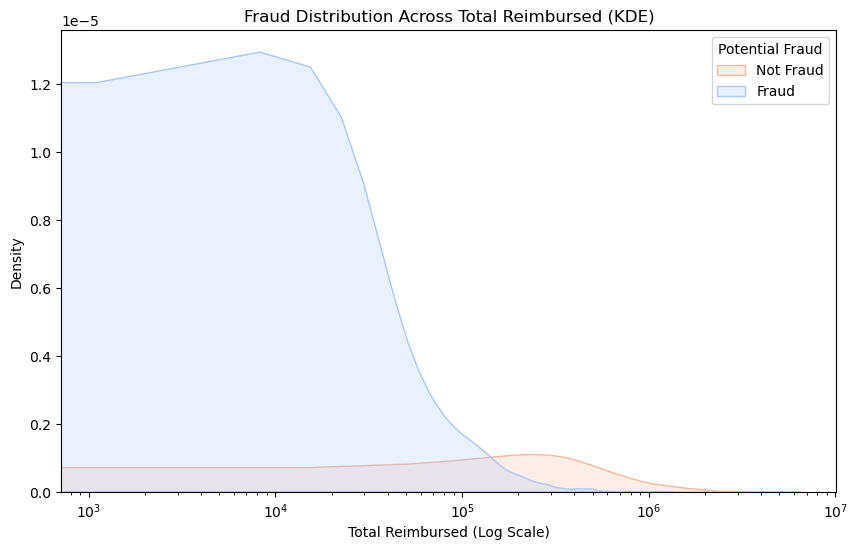

In [21]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Total_Reimbursed', hue='PotentialFraud', fill=True, common_norm=False, palette='coolwarm')  # Remove histplot
plt.xscale('log')  
plt.title("Fraud Distribution Across Total Reimbursed (KDE)")
plt.xlabel("Total Reimbursed (Log Scale)")
plt.ylabel("Density")
plt.legend(title="Potential Fraud", labels=["Not Fraud", "Fraud"])
plt.savefig("fraud_distribution_kde.png")
plt.show()


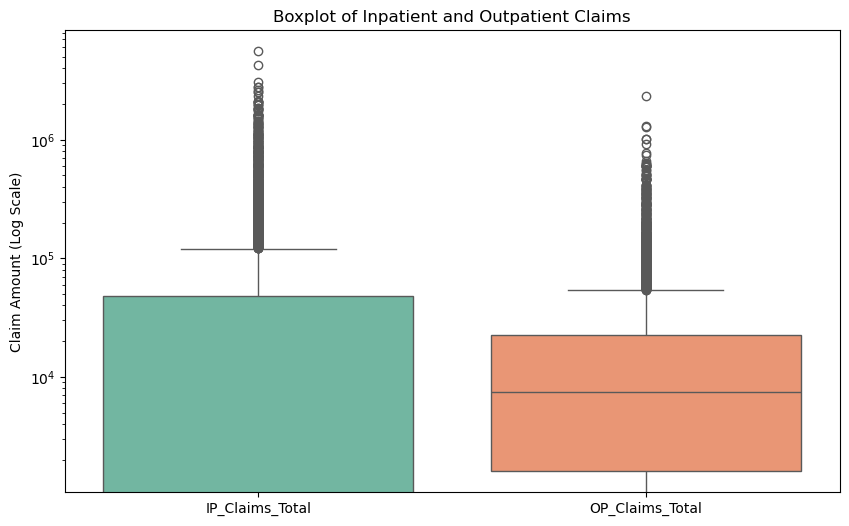

In [23]:
# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['IP_Claims_Total', 'OP_Claims_Total']], palette='Set2')
plt.yscale('log')
plt.title("Boxplot of Inpatient and Outpatient Claims")
plt.ylabel("Claim Amount (Log Scale)")
plt.savefig("boxplot_ip_op_claims.png")
plt.show()


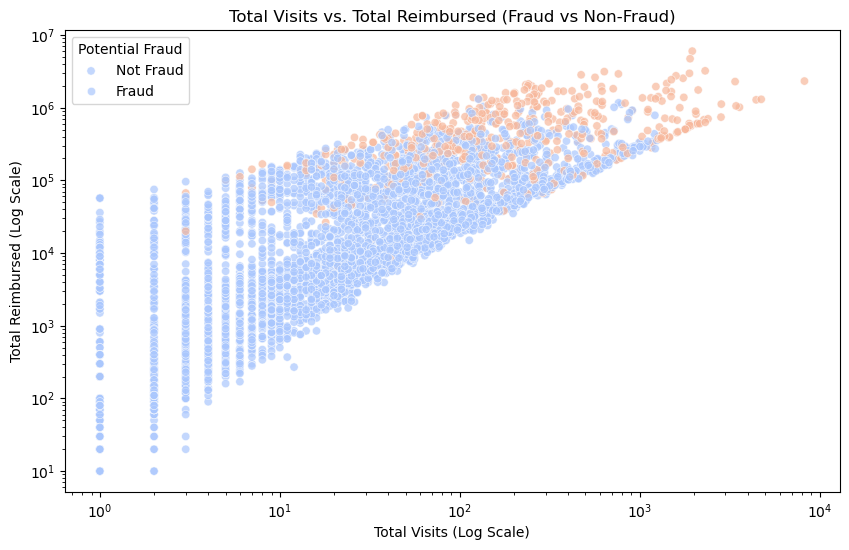

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Total_Visits', y='Total_Reimbursed', hue='PotentialFraud', alpha=0.7, palette='coolwarm')
plt.xscale('log')
plt.yscale('log')
plt.title("Total Visits vs. Total Reimbursed (Fraud vs Non-Fraud)")
plt.xlabel("Total Visits (Log Scale)")
plt.ylabel("Total Reimbursed (Log Scale)")
plt.legend(title="Potential Fraud", labels=["Not Fraud", "Fraud"])
plt.savefig("scatter_total_visits_reimbursed.png")
plt.show()


C:\Users\Chloe DeRouen\AppData\Local\Temp\ipykernel_22556\586616555.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["PotentialFraud"], palette="coolwarm")


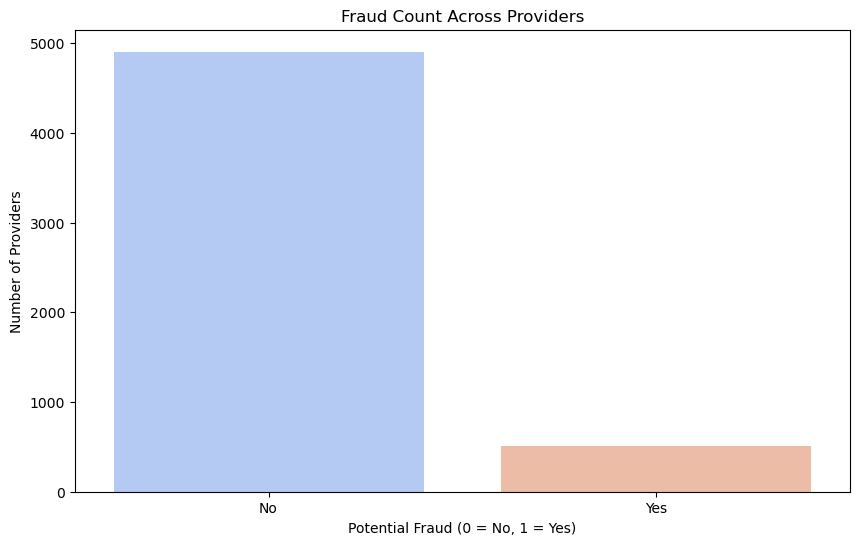

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df["PotentialFraud"], palette="coolwarm")
plt.title("Fraud Count Across Providers")
plt.xlabel("Potential Fraud (0 = No, 1 = Yes)")
plt.ylabel("Number of Providers")
plt.savefig("fraud_count_bar.png")
plt.show()
